In [1]:
import sys
sys.path.insert(0, '../../')
import MS2LDA
from MS2LDA.motif_parser import load_m2m_folder
import tomotopy as tp

# Fingerprint substructure overlap calculation

In [2]:
def calculate_sos(smaller_fp, bigger_fp):

    smaller_fp_sum = sum(smaller_fp)
    fp_intersection = 0
    for bit1, bit2 in zip(smaller_fp, bigger_fp):
        if bit1 == 1 and bit2 == 1:
            fp_intersection += 1

    if fp_intersection == 0:
        return 0
    else:
        return fp_intersection / smaller_fp_sum
    

## Importing the output of MS2LDA

In [3]:
import pickle
with open('/Users/rtlortega/Documents/PhD/WP1/WP1/Code/MS2LDA/notebooks/Paper_results/CaseStudy_NP_filtered_100motifs_output/doc2spec_map.pkl', 'rb') as f:
    doc2spec_map = pickle.load(f)

In [4]:
lda_model = tp.LDAModel.load('/Users/rtlortega/Documents/PhD/WP1/WP1/Code/MS2LDA/notebooks/Paper_results/CaseStudy_NP_filtered_100motifs_output/ms2lda.bin')

In [5]:
len(lda_model.docs)

1267

In [6]:
number_of_motifs = lda_model.k
number_of_documents = len(lda_model.docs)
print(f"Number of motifs: {number_of_motifs}")
print(f"Number of documents: {number_of_documents}")
docs_per_motif = [list() for _ in range(number_of_motifs)]
smiles_per_motif = [list() for _ in range(number_of_motifs)]
mag_per_motif = [list() for _ in range(number_of_motifs)]

Number of motifs: 100
Number of documents: 1267


### We substract the documents associated withe each motif, check tomotopy for more detail in the functions (like get_topics, maybe there are easier ways to do this)

In [7]:
for i in range(len(lda_model.docs)):
    topics = lda_model.docs[i].get_topics()
    docs_per_motif[topics[0][0]].append(i)

### Then we store the SMILES (annotation, coming from the library) per spectra (doc_id) ---> we have Mass2Motifs associated with the SMILES coming from the library

In [ ]:
for j, docs_id in enumerate(docs_per_motif):
    for doc_id in docs_id:
        smiles = MS2LDA.utils.retrieve_spec4doc(doc2spec_map, lda_model, doc_id).get("smiles")
        smiles_per_motif[j].append(smiles)

In [9]:
from MS2LDA.motif_parser import load_m2m_folder

In [10]:
motifs = load_m2m_folder('/Users/rtlortega/Documents/PhD/WP1/WP1/Code/MS2LDA/notebooks/Paper_results/CaseStudy_NP_filtered_100motifs_output/motifs/')

### Here we substract the Mass2Motifs MAG annotation

In [11]:
motifs_ordered = [list() for _ in range(number_of_motifs)]
for motif in motifs:
    motif_id = int(motif.get("id").split("_")[1])
    auto_annotation = eval(motif.get("auto_annotation"))
    for annotation in auto_annotation:
        mag_per_motif[motif_id].append(annotation)
    motifs_ordered[motif_id].append(motif)

In [12]:
from rdkit.Chem import MolFromSmiles, MolFromSmarts
from rdkit.Chem.Draw import MolsToGridImage

In [15]:
import numpy as np

In [16]:
import matplotlib.pyplot as plt

### Here startes the evaluation we are trying to build, but ths is ongoing work, basically its to check if the MCS (maximum common substructure) from the MAG annotation is present in the structure annotated from the library

In [17]:
is_subset = lambda a, b: np.all((a.astype(bool) & b.astype(bool)) == a.astype(bool))

In [18]:
from tqdm import tqdm
from rdkit.Chem import rdFMCS

In [19]:
from rdkit import Chem

def is_ring_only(mol):
    
    ri = mol.GetRingInfo()
    num_rings = len(ri.AtomRings())
    
    if num_rings == 0:
        return False
    
    else:
        print(num_rings)
    
    # Get all atoms that are part of any ring
    ring_atoms = [a for r in ri.AtomRings() for a in r]
    print(ring_atoms)
    
    # If all atoms in the molecule are ring atoms → ring-only pattern
    return len(ring_atoms) == mol.GetNumAtoms()

In [20]:
recalls, precisions, accuracies = [], [], []
num_atoms = []

doc_mols = [
    MolFromSmiles(MS2LDA.utils.retrieve_spec4doc(doc2spec_map, lda_model, doc_id).get("smiles"))
    for doc_id, doc in enumerate(lda_model.docs)
]

print("Starting substructure search...")

for k in range(number_of_motifs):
    if len(mag_per_motif) < 2:
        continue

    try:
        substructure = MolFromSmarts(rdFMCS.FindMCS([MolFromSmiles(smiles) for smiles in mag_per_motif[k][:4]], timeout=60, completeRingsOnly=True, ringMatchesRingOnly=True, bondCompare=rdFMCS.BondCompare.CompareAny).smartsString)
    except Exception:
        continue

    true_pos = true_neg = false_pos = false_neg = 0

    for doc_id, doc in enumerate(lda_model.docs):
        is_sub = doc_mols[doc_id].HasSubstructMatch(substructure)
        if is_ring_only(substructure) == True:
            print("Skipping ring-only substructure for motif", doc_id)
            break
        if doc.get_topics()[0][0] == k:
            if is_sub:
                true_pos += 1
            else:
                false_pos += 1
        else:
            if is_sub:
                false_neg += 1
            else:
                true_neg += 1

    recall = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
    precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    
    num_atom = substructure.GetNumAtoms()
    num_atoms.append(num_atom)

    if recall > 0:
        print(k, ":", true_pos, true_neg, false_pos, false_neg, recall, precision)


Starting substructure search...
0 : 3 472 0 792 0.0037735849056603774 1.0
1 : 11 65 0 1191 0.009151414309484194 1.0
2 : 17 65 0 1185 0.014143094841930116 1.0
3 : 11 1180 10 66 0.14285714285714285 0.5238095238095238
4 : 8 1240 18 1 0.8888888888888888 0.3076923076923077
5 : 18 64 1 1184 0.014975041597337771 0.9473684210526315
8 : 10 1237 13 7 0.5882352941176471 0.43478260869565216
9 : 1 29 0 1237 0.0008077544426494346 1.0
10 : 12 65 0 1190 0.009983361064891847 1.0
11 : 29 346 0 892 0.031487513572204126 1.0
12 : 12 1234 6 15 0.4444444444444444 0.6666666666666666
14 : 7 851 1 408 0.016867469879518072 0.875
15 : 7 155 0 1105 0.006294964028776978 1.0
17 : 2 1089 7 169 0.011695906432748537 0.2222222222222222
18 : 3 1123 6 135 0.021739130434782608 0.3333333333333333
19 : 3 957 9 298 0.009966777408637873 0.25
20 : 9 1235 21 2 0.8181818181818182 0.3
21 : 2 1252 12 1 0.6666666666666666 0.14285714285714285
22 : 3 446 16 802 0.0037267080745341614 0.15789473684210525
24 : 4 1252 11 0 1.0 0.266666666

### On going work....

In [24]:
from rdkit.Chem import rdFMCS

In [25]:
x = MolFromSmarts(rdFMCS.FindMCS([MolFromSmiles(smiles) for smiles in mag_per_motif[l][:5]], timeout=60, completeRingsOnly=True, ringMatchesRingOnly=True, bondCompare=rdFMCS.BondCompare.CompareAny).smartsString)

In [26]:
x.GetRingInfo().AtomRings()

()

In [27]:
Chem.MolToSmiles(x)

'C1:C:C:C:C:C:1'

In [28]:
import matplotlib.pyplot as plt

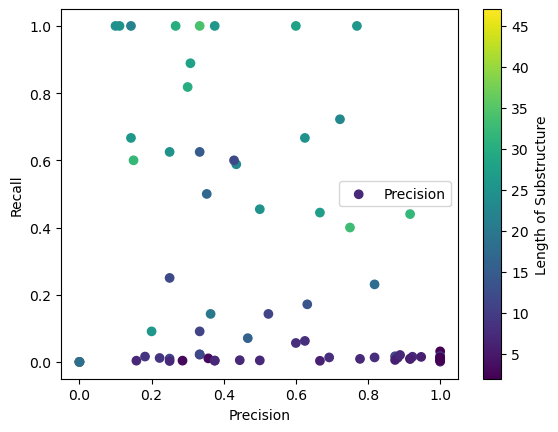

In [29]:
plt.scatter(precisions, recalls, label='Precision', c=num_atoms, cmap="viridis")
plt.ylabel('Recall')
plt.xlabel('Precision')
plt.colorbar(label='Length of Substructure')
plt.legend()

(0.0, 1.0)

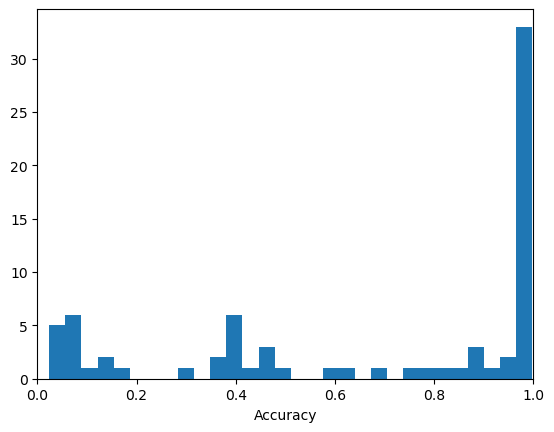

In [30]:
plt.hist(accuracies, bins=30)
plt.xlabel('Accuracy')
plt.xlim(0,1)

(0.0, 1.0)

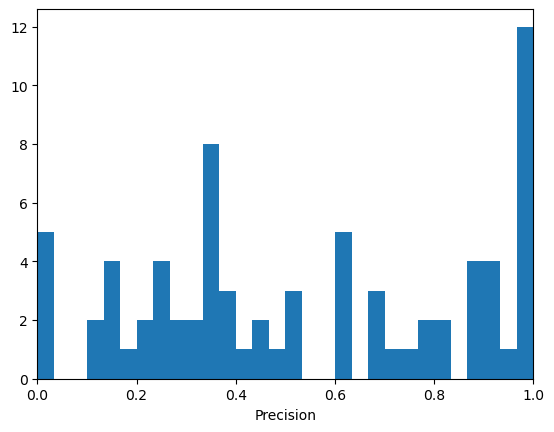

In [31]:
plt.hist(precisions, bins=30)
plt.xlabel('Precision')
plt.xlim(0,1)

(0.0, 1.0)

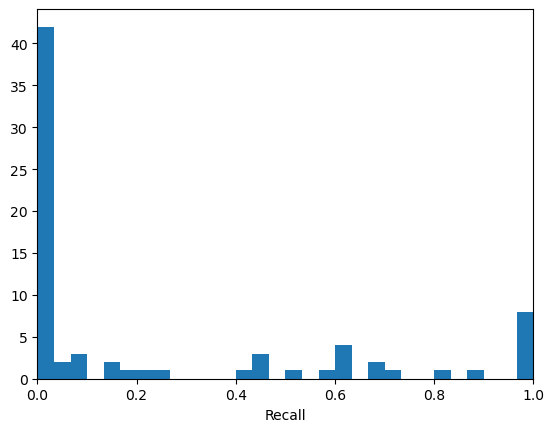

In [32]:
plt.hist(recalls, bins=30)
plt.xlabel('Recall')
plt.xlim(0,1)

In [33]:
accuracies

[0.3749013417521705,
 0.05998421468034728,
 0.06471981057616416,
 0.9400157853196527,
 0.9850039463299132,
 0.06471981057616416,
 0.984214680347277,
 0.02367797947908445,
 0.06077348066298342,
 0.2959747434885556,
 0.9834254143646409,
 0.6771902131018153,
 0.12786108918705605,
 0.8610891870560379,
 0.8887134964483031,
 0.7576953433307024,
 0.9818468823993686,
 0.98973954222573,
 0.35438042620363064,
 0.9913180741910024,
 0.98973954222573,
 0.9873717442778216,
 0.9905288082083662,
 0.9707971586424625,
 0.9905288082083662,
 0.9857932123125493,
 0.9715864246250987,
 0.47908445146014206,
 0.9865824782951855,
 0.3867403314917127,
 0.056037884767166535,
 0.9968429360694554,
 0.6243093922651933,
 0.9707971586424625,
 0.7868981846882399,
 0.994475138121547,
 0.38595106550907654,
 0.9881610102604578,
 0.9921073401736386,
 0.056827150749802685,
 0.9486977111286503,
 0.10891870560378848,
 0.9921073401736386,
 0.3851617995264404,
 0.9826361483820047,
 0.16258879242304658,
 0.5872138910812944,
 0.0